In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
import argparse
pd.set_option('display.max_rows', None)

# analyze_tau version that only applies tau correction to core range (but, includes all points in optimization)
# (cleaned-up version of 3-region analyze_tau script, also using slope tau optimization)

In [17]:
# Define functions to process data

def drop_obs(region_orig_obsdata, full_orig_obsdata):
    #drop any observations from 1 region that aren't in another (make sure they all have same # of obs)
    #   region_orig_obsdata: list, of the 3 dataframes (1 per region)
    #   full_orig_obsdata: dataframe, of the full image 
    

    #find common observations between the 3 different regions
    common_obs = pd.Series(list(set(region_orig_obsdata[0].Observation) \
                                & set(region_orig_obsdata[1].Observation)\
                                & set(region_orig_obsdata[2].Observation)))
    
    
    #store all of the obsdata with uncommon obs dropped
    region_dropped_obsdata = []
    
    #for each region, remove observations not in the list of common observations
    for obsdata in region_orig_obsdata:
        
        #keep only observations in the common list
        obsdata = obsdata[obsdata.Observation.isin(common_obs)]
        
        #reset indices (so they all match)
        obsdata = obsdata.reset_index(drop=True)
        
        #save list of observations (now having dropped any not in common)
        region_dropped_obsdata.append(obsdata)
    
    
    #also remove uncommon obs from, reindex full-image dataframe
    full_orig_obsdata = full_orig_obsdata[full_orig_obsdata.Observation.isin(common_obs)]
    full_orig_obsdata = full_orig_obsdata.reset_index(drop=True)
    
    print('Removed uncommon OBSIDs:', set(set(region_orig_obsdata[0].Observation) \
                                & set(region_orig_obsdata[1].Observation)\
                                ^ set(region_orig_obsdata[2].Observation)))
    print('Unique observation names:', len(full_orig_obsdata))
    print()
    
    return region_dropped_obsdata, full_orig_obsdata


def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(orig_obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)

    for obsid in outlier_obs:
        #drop row containing outlier ob
        orig_obsdata = orig_obsdata[orig_obsdata.Observation != obsid]
            
    #reset indices (so they all match)
    obsdata = orig_obsdata.reset_index(drop=True)
    
    print('Removed outlier OBSIDs:', set(outlier_obs))
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata


In [18]:
# Define variables

# directory of dumped EW csv files
dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'

#use all 3 regions, 4 boundaries between the regions
radii = ['139220', '140120', '140320', '141220']

size = '0' #slice/step size of the csv file, currently only have 0

#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#list outlier obsids
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']

In [19]:
# Read in the CSV files (full-width, then the 3 different regions)

#get the full-width image data
full_img_filepath = dump_ew_dir+'core/rin'+radii[0]+'_rout'+radii[3]+'/slice'+size+'_ew_stats.csv'
full_orig_obsdata = pd.read_csv(full_img_filepath, parse_dates=['Date']); ms=20; alpha=0.7

#calculate mu, mu0 
full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

In [20]:
# Read in the CSV files for each of the 3 regions
filepath1 = dump_ew_dir+'inner/rin'+radii[0]+'_rout'+str(int(radii[1])-1)+'/slice'+size+'_ew_stats.csv'
filepath2 = dump_ew_dir+'core/rin'+radii[1]+'_rout'+str(int(radii[2])-1)+'/slice'+size+'_ew_stats.csv'
filepath3 = dump_ew_dir+'outer/rin'+radii[2]+'_rout'+radii[3]+'/slice'+size+'_ew_stats.csv'

filepaths = [filepath1, filepath2, filepath3]

region_orig_obsdata = []

i = 1
for filepath in filepaths:
    orig_obsdata = pd.read_csv(filepath, parse_dates=['Date']); ms=20; alpha=0.7
    
    region_orig_obsdata.append(orig_obsdata)
    
    #print initial statistics for each region
    print('Region '+str(i))
    print('** SUMMARY STATISTICS **')
    print('Unique observation names:', len(orig_obsdata.groupby('Observation')))
    print('Total slices:', len(orig_obsdata))
    print('Starting date:', orig_obsdata['Date'].min())
    print('Ending date:', orig_obsdata['Date'].max())
    print('Time span:', orig_obsdata['Date'].max()-orig_obsdata['Date'].min())
    print()
    
    print(filepath)
    print()
    
    i+=1

Region 1
** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/Users/mlessard/REU_2022/data/dump_ew_csv/inner/rin139220_rout140119/slice0_ew_stats.csv

Region 2
** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/Users/mlessard/REU_2022/data/dump_ew_csv/core/rin140120_rout140319/slice0_ew_stats.csv

Region 3
** SUMMARY STATISTICS **
Unique observation names: 148
Total slices: 148
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/Users/mlessard/REU_2022/data/dump_ew_csv/outer/rin140320_rout141220/slice0_ew_stats.csv



In [21]:
# Ensure each of the 3 regions, full-image dataframes are of same length so they can be joined together
# (drop any observations that don't match between the 3 regions)
region_orig_obsdata, full_orig_obsdata = drop_obs(region_orig_obsdata, full_orig_obsdata)

Removed uncommon OBSIDs: {'ISS_007RI_LPHRLFMOV001_PRIME', 'ISS_243RF_FMOVIE001_PRIME_1', 'ISS_178RI_EGAPMOVMP001_PRIME'}
Unique observation names: 148



In [22]:
#then, merge them into a single dataframe
#combine the Normal EW values from the other 3 regions (1-inner, 2-core, 3-outer) into full_orig dataframe
region_normal_ews = [region_orig_obsdata[i]['Normal EW'] for i in range(3)]

full_orig_obsdata['Normal EW1'] = region_normal_ews[0] #inner
full_orig_obsdata['Normal EW2'] = region_normal_ews[1] #core
full_orig_obsdata['Normal EW3'] = region_normal_ews[2] #outer


In [23]:
#remove EQX observations
removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

#remove outliers
obsdata = remove_outliers(removed_eqx_obsdata, outliers)

Removed EQX OBSIDs: {'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME'}
Unique observation names: 142

Removed outlier OBSIDs: {'ISS_091RF_FMOVIE003_PRIME', 'ISS_189RF_FMOVIE001_PRIME', 'ISS_107RF_FMOVIE002_PRIME'}
Unique observation names: 139



<h1> Optimize Tau for Low-Phase Observations </h1>

In [24]:
# Find "small" (<6) e or i
low_phase_mask = obsdata['Mean Phase'] <= 60
low_phase_obsdata = obsdata[low_phase_mask]
lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
low_i_mask = np.abs(obsdata['Incidence']-90) < 6
low_ei_mask = low_e_mask | low_i_mask

In [25]:
# Find the optimal tau to minimize scatter
# only apply the tau correction to the core/Region 2, but use all 3's values to optimize w/ slope/scatter/etc.
# also only use the low-phase data to calculate
best_tau = None
best_slope = 1e38
for tau in np.arange(0.000, 0.101, 0.001):
    
    #get the tau-adjusted EW values for the core/Region 2
    core_corrected_ew = compute_corrected_ew(low_phase_obsdata['Normal EW2'], 
                                             low_phase_obsdata['Mean Emission'], 
                                             low_phase_obsdata['Incidence'], 
                                             tau=tau)
    #add this value to the inner/Region 1 outer/Region 3 Normal EW values to get overall corrected Normal EW value
    corrected_ew = low_phase_obsdata['Normal EW1'] + core_corrected_ew + low_phase_obsdata['Normal EW3']
    
    coeff = np.polyfit(low_phase_obsdata['Mu0'], corrected_ew, 1)
    if abs(coeff[0]) < best_slope:
        best_slope = abs(coeff[0])
        best_tau = tau
    #print(f'Tau {tau:.3f} - Slope: {coeff[0]:8.5f}')

print()
print(f'** Best Tau: {best_tau:.3f}')


** Best Tau: 0.059


In [26]:
#add columns with total (all 3 regions') uncorrected EW, corrected EW (the latter using best-fit tau)
#do for both full, low 

#total uncorrected EW:
total_uc_ew = obsdata['Normal EW1'] + obsdata['Normal EW2'] + obsdata['Normal EW3']

#total corrected EW:
core_c_ew = compute_corrected_ew(obsdata['Normal EW2'], 
                                 obsdata['Mean Emission'], 
                                 obsdata['Incidence'], 
                                 tau=best_tau)
total_c_ew = obsdata['Normal EW1'] + core_c_ew + obsdata['Normal EW3']

#add values as additional columns to dataframes
obsdata['Total UC EW'] = total_uc_ew
obsdata['Total C EW'] = total_c_ew

#recalculate values for low-ei, low-phase observations (now that Total EW values have been added)
low_phase_mask = obsdata['Mean Phase'] <= 60
low_phase_obsdata = obsdata[low_phase_mask]
lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
low_i_mask = np.abs(obsdata['Incidence']-90) < 6
low_ei_mask = low_e_mask | low_i_mask

In [27]:
#calculate means of uncorrected (UC) vs. corrected (C) low-phase data, display

print()
print('Uncorrected Low Phase:')
uc_mean_low = np.mean(low_phase_obsdata['Total UC EW'][lp_low_ei_mask])
uc_mean_notlow = np.mean(low_phase_obsdata['Total UC EW'][~lp_low_ei_mask])
print(f'Mean Normal EW Low E/I: {uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {uc_mean_notlow:.5f}')
print(f'Other/Low: {uc_mean_notlow/uc_mean_low:.5f}')
print()

lp_corrected_ew = low_phase_obsdata['Total C EW']
mean_low = np.mean(lp_corrected_ew[lp_low_ei_mask])
mean_notlow = np.mean(lp_corrected_ew[~lp_low_ei_mask])
print(f'Corrected (tau={best_tau:.3f}) Low Phase:')
print(f'Mean Normal EW Low E/I: {mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow:.5f}')
print(f'Other/Low: {mean_notlow/mean_low:.5f}')

print()
print('Overall change due to Tau:')
print(f'Mean Normal EW Low E/I: {mean_low/uc_mean_low:.5f}')
print(f'Mean Normal EW Other:   {mean_notlow/uc_mean_notlow:.5f}')


Uncorrected Low Phase:
Mean Normal EW Low E/I: 0.51446
Mean Normal EW Other:   0.58467
Other/Low: 1.13646

Corrected (tau=0.059) Low Phase:
Mean Normal EW Low E/I: 0.67323
Mean Normal EW Other:   0.66731
Other/Low: 0.99121

Overall change due to Tau:
Mean Normal EW Low E/I: 1.30861
Mean Normal EW Other:   1.14136


In [28]:
# Find H-G phase curve for full dataset
corrected_ew = obsdata['Total C EW']

#make 'Multi Normal EW' column the uncorrected values for the moment (to submit to hg function)
obsdata['Multi Normal EW'] = obsdata['Total UC EW']
uc_hg_params, uc_hg_used_data, uc_hg_std = fit_hg_phase_function(2, None, obsdata, 
                                                                 verbose=False, multi_regions=True)
print()
print('Uncorrected H-G params:')
print_hg_params(uc_hg_params, indent=2)
print(f'  Standard deviation: {uc_hg_std:.5f}')


#make 'Multi Normal EW' column the CORRECTED values now (to submit to hg function)
obsdata['Multi Normal EW'] = obsdata['Total C EW']
#(do NOT submit a best_tau value to function, already applied tau correction on center alone)
hg_params, hg_used_data, hg_std = fit_hg_phase_function(2, None, obsdata, 
                                                        verbose=False, multi_regions=True)
print()
print(f'Corrected (tau={best_tau:.3f}) params:')
print_hg_params(hg_params, indent=2)
print(f'  Standard deviation: {hg_std:.5f}')


Uncorrected H-G params:
  g1 = 0.648 weight1 = 0.648
  g2 = 0.022 weight2 = 0.352
  Standard deviation: 0.05292

Corrected (tau=0.059) params:
  g1 = 0.632 weight1 = 0.660
  g2 = -0.015 weight2 = 0.340
  Standard deviation: 0.05331


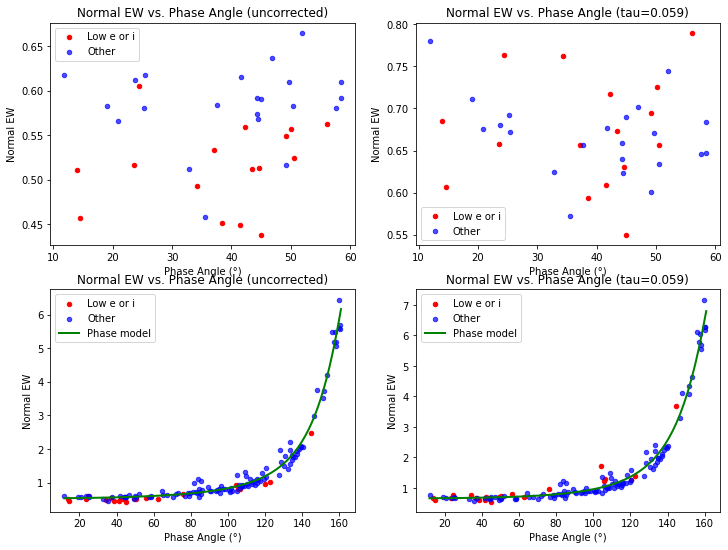

In [29]:
# Plot results
plt.figure(figsize=(12,9)) 
plt.subplot(2, 2, 1) #figure 1: low-phase, uncorrected
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            low_phase_obsdata['Total UC EW'][lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            low_phase_obsdata['Total UC EW'][~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(2, 2, 2) #figure 2: low-phase, corrected
plt.scatter(low_phase_obsdata['Mean Phase'][lp_low_ei_mask], 
            lp_corrected_ew[lp_low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(low_phase_obsdata['Mean Phase'][~lp_low_ei_mask], 
            lp_corrected_ew[~lp_low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')

plt.subplot(2, 2, 3) #figure 3: all data, uncorrected
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            obsdata['Total UC EW'][low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            obsdata['Total UC EW'][~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
uc_hg_phase_model = hg_func(uc_hg_params, np.radians(xrange))
plt.plot(xrange, uc_hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

plt.subplot(2, 2, 4) #figure 4: all data, corrected
plt.scatter(obsdata['Mean Phase'][low_ei_mask], 
            corrected_ew[low_ei_mask], 
            s=ms, c='red', label='Low e or i')
plt.scatter(obsdata['Mean Phase'][~low_ei_mask], 
            corrected_ew[~low_ei_mask], 
            s=ms, alpha=alpha, c='blue', label='Other')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
hg_phase_model = hg_func(hg_params, np.radians(xrange))
plt.plot(xrange, hg_phase_model, '-', color='green', lw=2, label='Phase model')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title(f'Normal EW vs. Phase Angle (tau={best_tau:.3f})')
plt.show()

Text(0.5, 1.0, 'Normal EW vs. Phase Angle (uncorrected)')

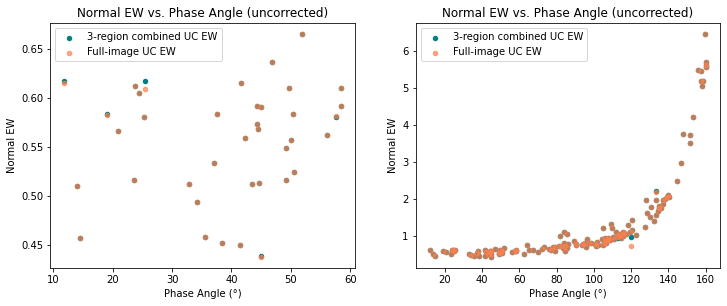

In [30]:
# plot the original Normal EW values against the combined (UC) EW values from the 3 regions
plt.figure(figsize=(12,4.5)) 
plt.subplot(1,2,1)
plt.scatter(low_phase_obsdata['Mean Phase'], 
            low_phase_obsdata['Total UC EW'], 
            s=ms, c='teal', label='3-region combined UC EW')
plt.scatter(low_phase_obsdata['Mean Phase'], 
            low_phase_obsdata['Normal EW'], 
            s=ms, alpha=alpha, c='coral', label='Full-image UC EW')
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')


plt.subplot(1,2,2)
plt.scatter(obsdata['Mean Phase'], 
            obsdata['Total UC EW'], 
            s=ms, c='teal', label='3-region combined UC EW')
plt.scatter(obsdata['Mean Phase'], 
            obsdata['Normal EW'], 
            s=ms, alpha=alpha, c='coral', label='Full-image UC EW')
xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
plt.legend()
plt.xlabel('Phase Angle (°)')
plt.ylabel('Normal EW')
plt.title('Normal EW vs. Phase Angle (uncorrected)')

